In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

IMAGES_DIR = "../doc/images"

In [2]:
# Hardcoded from the Serial benchmark OMP practise
serial_data = {
  "N":      [1000,   1000,    1000,     1000,
         100,    100,      100,       100,
        2000,   2000,    2000,     2000],
  "M":      [1000,   1000,    1000,     1000,
         100,    100,      100,       100,
        2000,   2000,    2000,     2000],
  "steps":  [100,    1000,    10000,    100000,
         100,     1000,    10000,    100000,
         100,     1000,    10000,    100000],
  "time":   [1.200000, 12.780000, 119.870000, 1070.680000,
         0.010000,  0.100000,   1.080000,   10.820000,
         4.750000,  47.630000, 503.060000, 4310.300000]
}
df_serial = pd.DataFrame(serial_data)
df_serial

,N,M,steps,time
0,1000,1000,100,1.20
1,1000,1000,1000,12.78
2,1000,1000,10000,119.87
3,1000,1000,100000,1070.68
4,100,100,100,0.01
5,100,100,1000,0.10
6,100,100,10000,1.08
7,100,100,100000,10.82
8,2000,2000,100,4.75
9,2000,2000,1000,47.63


In [3]:
df = pd.read_csv('../results/raw/run2/all_results.csv', delimiter=';')
df.head()

,thread,max threads,time,N,M,steps
0,1,2,3.137679,1000,1000,100
1,0,2,3.226295,1000,1000,100
2,1,2,28.648657,1000,1000,1000
3,0,2,28.773441,1000,1000,1000
4,1,2,269.518831,1000,1000,10000


In [4]:
df_simple = df.groupby(["max threads", "N", "M", "steps"], as_index=False).time.max()
df_simple.head()

,max threads,N,M,steps,time
0,2,100,100,100,3.008608
1,2,100,100,1000,30.182583
2,2,100,100,10000,151.455907
3,2,100,100,100000,997.242430
4,2,1000,1000,100,3.226295


In [5]:
def create_pivot_for_max_threads(max_threads)-> pd.DataFrame:
  df_filtered = df_simple[df_simple["max threads"] == max_threads].copy()
  df_filtered["NM"] = df_filtered["N"].astype(str) + "x" + df_filtered["M"].astype(str)
  return df_filtered.pivot_table(index="NM", columns="steps", values="time")

In [6]:
for max_threads in df_simple["max threads"].unique():
  df_pivot = create_pivot_for_max_threads(max_threads)
  df_pivot.columns = [str(col) for col in df_pivot.columns]
  df_pivot.index.name = "N x M"
  df_pivot.columns.name = "steps"
  print(f"Nodes: {max_threads}")
  print(df_pivot)
  print()



Nodes: 2
steps           100       1000       10000       100000
N x M                                                  
1000x1000  3.226295  28.773441  269.608456  2451.152783
100x100    3.008608  30.182583  151.455907   997.242430
2000x2000  4.463269  42.416510  323.633867  2576.611911

Nodes: 4
steps           100       1000       10000       100000
N x M                                                  
1000x1000  3.466167  32.299433  318.805040  3184.036661
100x100    2.661267  26.713319  372.033094  2572.231210
2000x2000  5.508030  47.554560  437.503118  3524.018770

Nodes: 5
steps           100       1000       10000       100000
N x M                                                  
1000x1000  2.874023  27.269382  382.538333  3183.711562
100x100    2.222764  23.600960  310.150252  3098.737703
2000x2000  4.407035  36.218476  428.217962  3336.180224



In [ ]:
def plot_time_steps_and_size(df, threads):
       subset = df[df["max threads"] == threads].copy()
       subset["Size"] = subset["N"].astype(str) + "x" + subset["M"].astype(str)
       subset = subset.sort_values("steps")
       

       sns.set_theme(style="whitegrid", palette="colorblind")
       
       plt.figure(figsize=(8, 5))
       ax = sns.lineplot(
              data=subset,
              x="steps",
              y="time",
              hue="Size",
              marker="o"
       )
       
       ax.set_title(f"Time for {threads} nodes", fontsize=14)
       ax.set_xlabel("Steps", fontsize=12)
       ax.set_ylabel("Time (s)", fontsize=12)
       ax.grid(True, linestyle="--", linewidth=0.5)
       plt.legend(title="Size", title_fontsize=12, fontsize=10)
       plt.tight_layout()
       plt.show()
       plt.savefig(f"{IMAGES_DIR}/plot_time_steps_and_size_{threads}.png", dpi=300)

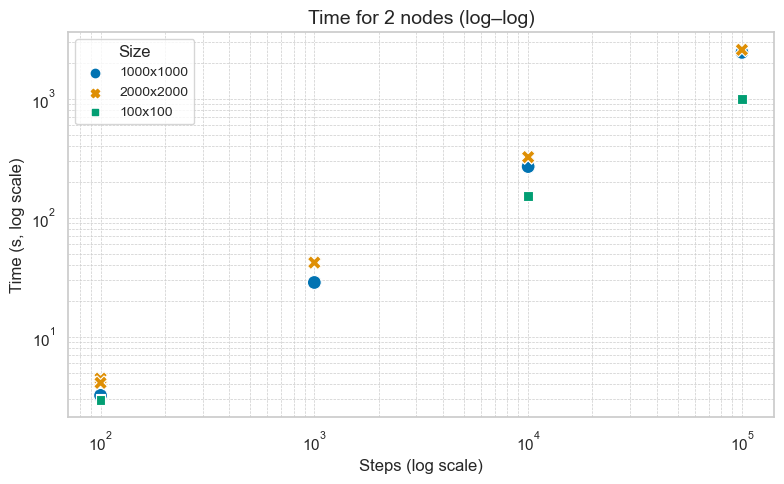

<Figure size 640x480 with 0 Axes>

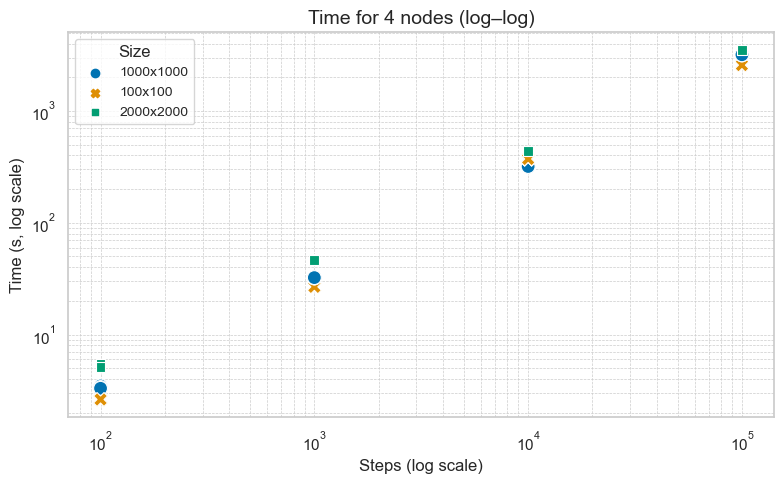

<Figure size 640x480 with 0 Axes>

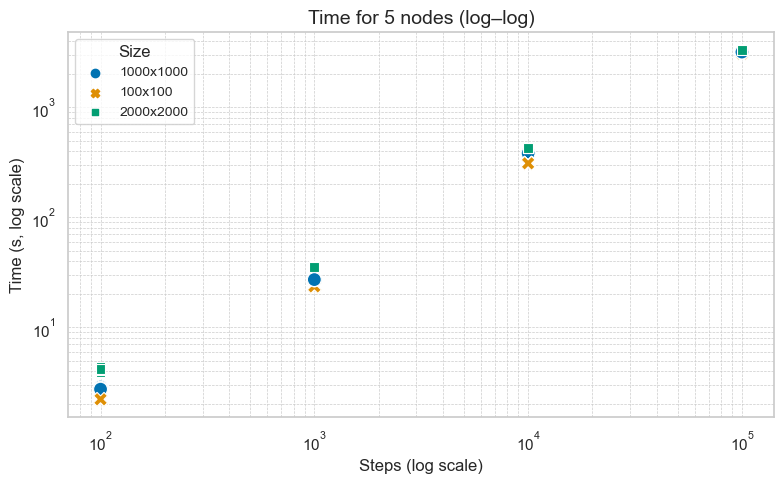

<Figure size 640x480 with 0 Axes>

In [16]:
for max_threads in df_simple["max threads"].unique():
  plot_time_steps_and_size(df, max_threads)

### Speedup Comparison

In [9]:
# calculate speedup of the MPI implementation over the serial run
df_sp = df_simple.merge(
  df_serial.rename(columns={'time': 'serial_time'}),
  on=['N', 'M', 'steps']
)
df_sp['speedup'] = df_sp['serial_time'] / df_sp['time']

# display the raw speedup table
df_sp[['max threads', 'N', 'M', 'steps', 'time', 'serial_time', 'speedup']]

# optional: pivot so that each column is a thread‐count
speedup = df_sp.pivot_table(
  index=['N', 'M', 'steps'],
  columns='max threads',
  values='speedup'
)
speedup

max threads              2         4         5
N    M    steps                               
100  100  100     0.003324  0.003758  0.004499
          1000    0.003313  0.003743  0.004237
          10000   0.007131  0.002903  0.003482
          100000  0.010850  0.004206  0.003492
1000 1000 100     0.371944  0.346204  0.417533
          1000    0.444160  0.395673  0.468657
          10000   0.444608  0.375998  0.313354
          100000  0.436807  0.336265  0.336299
2000 2000 100     1.064242  0.862377  1.077822
          1000    1.122912  1.001586  1.315075
          10000   1.554411  1.149843  1.174776
          100000  1.672856  1.223121  1.291987

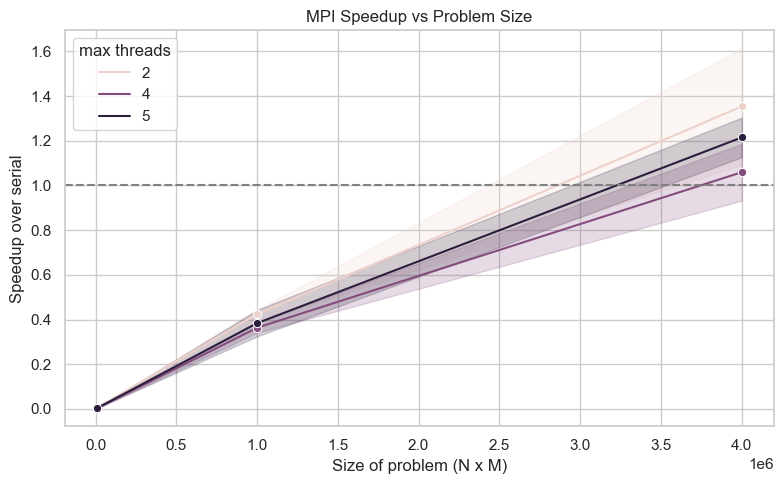

<Figure size 640x480 with 0 Axes>

In [11]:
# Plot MPI speedup vs a measure of problem size and highlight where speedup crosses 1
sp = df_sp.copy()
# define a simple work metric
sp['work'] = sp['N'] * sp['M']

plt.figure(figsize=(8, 5))
ax = sns.lineplot(
  data=sp,
  x='work',
  y='speedup',
  hue='max threads',
  marker='o'
)


# horizontal line at speedup = 1 (sequential performance)
ax.axhline(1, ls='--', color='gray')


ax.set_xlabel('Size of problem (N x M)')
ax.set_ylabel('Speedup over serial')
ax.set_title('MPI Speedup vs Problem Size')
plt.tight_layout()
plt.show()
plt.savefig(f"{IMAGES_DIR}/mpi_speedup.png", dpi=300)
